In [6]:
# Imports & optional installs
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modeling libs (install if missing)
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None

# Optional interpretability libs (install if needed)
try:
    import shap
except Exception:
    shap = None
try:
    import eli5
    from eli5.sklearn import PermutationImportance
except Exception:
    eli5 = None


In [7]:
# --- Load dataset ---
file_path = 'final.csv'  # adjust path if needed
df = pd.read_csv(file_path)

# Ensure Date column and set as index
if 'Date' not in df.columns:
    raise ValueError("No 'Date' column found in CSV. Please include a 'Date' column.")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).set_index('Date')

# Drop useless weather features explicitly requested
for col in ['Precipitation', 'Wind_Speed', 'Air_Pressure', 'Air_Pressure(hPa)','Unit','Commodity','Season']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Basic forward-fill for any remaining missing values (safe for daily series)
df = df.ffill().bfill()
print('Loaded dataframe shape:', df.shape)
print('Columns:', df.columns.tolist())

Loaded dataframe shape: (1389, 14)
Columns: ['Average_Price', 'Supply_Volume', 'Temperature', 'Rainfall_MM', 'Diesel', 'is_festival', 'Import_tomato_price', 'Season_Autumn', 'Season_Monsoon', 'Season_Spring', 'Season_Winter', 'Inflation', 'Import_Quantity', 'Exchange_Rate']


In [8]:
df.head()

,Average_Price,Supply_Volume,Temperature,Rainfall_MM,Diesel,is_festival,Import_tomato_price,Season_Autumn,Season_Monsoon,Season_Spring,Season_Winter,Inflation,Import_Quantity,Exchange_Rate
Date,,,,,,,,,,,,,,
2022-01-01,115.00,0.0,9.0,0.0,119.0,0,101.00,False,False,False,True,6.03,6317971.0,118.64
2022-01-02,115.00,8000.0,9.8,0.0,119.0,0,115.00,False,False,False,True,6.03,6317971.0,118.64
2022-01-03,95.00,22375.0,10.0,0.0,119.0,0,95.00,False,False,False,True,6.03,6317971.0,118.64
2022-01-04,96.67,8000.0,10.2,0.0,119.0,0,96.67,False,False,False,True,6.03,6317971.0,118.52
2022-01-05,86.67,32500.0,11.0,0.0,119.0,0,86.67,False,False,False,True,6.03,6317971.0,118.99


In [9]:
# --- Feature engineering class ---
class TomatoPriceFeatureEngineer:
    def __init__(self, lag_periods=[1,7,30], rolling_windows=[7,30], target_col='Average_Price'):
        self.lag_periods = lag_periods
        self.rolling_windows = rolling_windows
        self.target_col = target_col

    def fit_transform(self, df_in):
        df = df_in.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError('DataFrame must have DateTime index')

        candidates = [self.target_col, 'Temperature', 'Rainfall_MM', 'Supply_Volume']
        for col in candidates:
            if col in df.columns:
                for lag in self.lag_periods:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
                for w in self.rolling_windows:
                    df[f'{col}_rollmean_{w}'] = df[col].rolling(window=w, min_periods=1).mean()
                    df[f'{col}_rollstd_{w}'] = df[col].rolling(window=w, min_periods=1).std().fillna(0)

        # Time features & cyclical encodings
        df['Month'] = df.index.month
        df['DayOfWeek'] = df.index.dayofweek
        df['Year'] = df.index.year
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Dow_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
        df['Dow_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

        # Drop rows introduced by shifting
        df = df.dropna()
        return df

    # Backwards-compat alias
    def create_features(self, df_in):
        return self.fit_transform(df_in)


In [10]:
# Apply feature engineering
fe = TomatoPriceFeatureEngineer()
df_processed = fe.create_features(df)
print('Processed shape:', df_processed.shape)
df_processed.head()

Processed shape: (1359, 49)


,Average_Price,Supply_Volume,Temperature,Rainfall_MM,Diesel,is_festival,Import_tomato_price,Season_Autumn,Season_Monsoon,Season_Spring,...,Supply_Volume_rollstd_7,Supply_Volume_rollmean_30,Supply_Volume_rollstd_30,Month,DayOfWeek,Year,Month_sin,Month_cos,Dow_sin,Dow_cos
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,66.67,18000.0,9.20,0.0,122.0,0,66.67,False,False,False,...,9785.040818,13329.166667,10751.477612,1,0,2022,0.500000,0.866025,0.000000,1.000000
2022-02-01,69.17,25500.0,8.35,0.0,122.0,0,56.67,False,False,False,...,10343.073367,13912.500000,10925.696833,2,1,2022,0.866025,0.500000,0.781831,0.623490
2022-02-02,71.67,33000.0,7.50,0.0,122.0,0,56.67,False,False,False,...,12800.320867,14266.666667,11372.547734,2,2,2022,0.866025,0.500000,0.974928,-0.222521
2022-02-03,74.17,40500.0,6.65,0.0,122.0,0,65.00,False,False,False,...,15459.913602,15350.000000,12267.729956,2,3,2022,0.866025,0.500000,0.433884,-0.900969
2022-02-04,76.67,48000.0,5.80,0.0,122.0,0,76.67,False,False,False,...,15734.686433,15866.666667,13298.055882,2,4,2022,0.866025,0.500000,-0.433884,-0.900969


In [11]:
# --- Preprocessing: split + scale ---
target = 'Average_Price'
if target not in df_processed.columns:
    raise ValueError('Target Average_Price missing in processed dataframe')

features = [c for c in df_processed.columns if c != target]
X = df_processed[features]
y = df_processed[target]

# Time-based split 80/20
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size].copy(), y.iloc[train_size:].copy()

# Columns to exclude from scaling (time/cyclical)
exclude = ['Year','Month','DayOfWeek','Month_sin','Month_cos','Dow_sin','Dow_cos']

# --- SAFER: select numeric columns only, then remove excluded ones ---
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scale_cols = [c for c in numeric_cols if c not in exclude]

# Initialize scaler
scaler = StandardScaler()

# Prepare scaled copies (only scale numeric columns)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit on train numeric cols and transform; keep other cols untouched
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

# If any NaNs appear after scaling (edge cases), fill with column medians from train
if X_train_scaled[scale_cols].isna().any().any() or X_test_scaled[scale_cols].isna().any().any():
    medians = X_train[scale_cols].median()
    X_train_scaled[scale_cols] = X_train_scaled[scale_cols].fillna(medians)
    X_test_scaled[scale_cols] = X_test_scaled[scale_cols].fillna(medians)

print('Train/test sizes:', X_train_scaled.shape, X_test_scaled.shape)

Train/test sizes: (1087, 48) (272, 48)


In [12]:
# --- Metrics utility (RMSE, MSE, MAE, MAPE, R2) ---
def regression_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true != 0
    mape = np.nan
    if mask.sum() > 0:
        mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

# test quick (will run on training data later)
print('Metrics util ready')

Metrics util ready


In [16]:
# --- Define base models ---
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=5000),
    # Use n_jobs=1 to avoid multiprocessing issues on this environment
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=1)
}
if xgb is not None:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=1)
if lgb is not None:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(random_state=42, n_jobs=1)

print("Models defined:", list(models.keys()))

Models defined: ['Linear', 'Ridge', 'Lasso', 'RandomForest', 'XGBoost', 'LightGBM']


CV for Linear
CV for Ridge
CV for Lasso
CV for Ridge
CV for Lasso
CV for RandomForest
CV for RandomForest
CV for XGBoost
CV for XGBoost
CV for LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1397
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 38
[LightGBM] [Info] Start training from score 77.521208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

RMSE                 MSE                 MAE           \
                 mean      std       mean        std     mean      std   
Model                                                                    
Lasso          6.2314   1.9253    41.7962    25.7440   3.9827   1.3530   
LightGBM       8.9224   3.2782    88.2063    65.4710   6.4860   2.3184   
Linear        28.4840  36.5907  1882.4409  3733.0563  18.4392  19.4148   
RandomForest   7.9329   2.9770    70.0203    54.7179   5.6193   2.1470   
Ridge          8.0565   2.3200    69.2130    41.6071   6.0283   1.7194   
XGBoost        9.2250   3.0472    92.5298    58.8426   6.8731   2.3418   

                 MAPE               R²           
                 mean      std    mean      std  
Model                                            
Lasso          6.3710   2.1724  0.8579   0.0687  
LightGBM      11.1683   4.4097  0.6571   0.3323  
Linear        29.0521  30.0205 -6.4730  13.6052  
RandomForest   9.5607   3.4313  0.7599   0.1763  
Ridge          9.4950   2.2949  0.7511   0.1254  
XGBoost       11.8788   4.5225  0.6396   0.3376

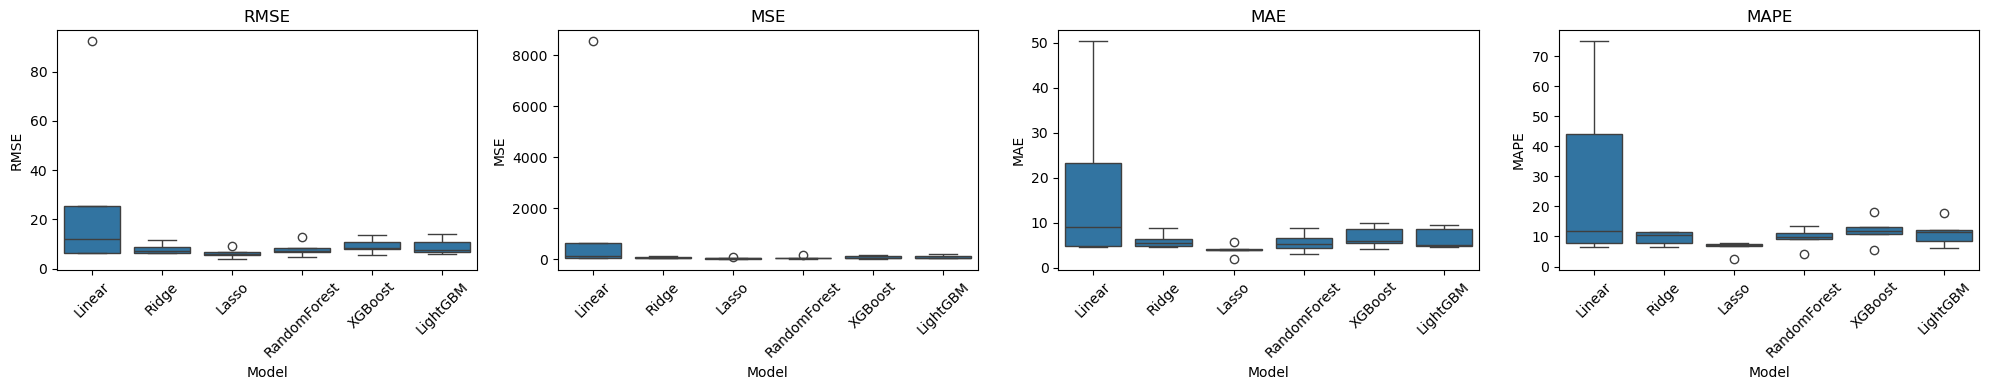

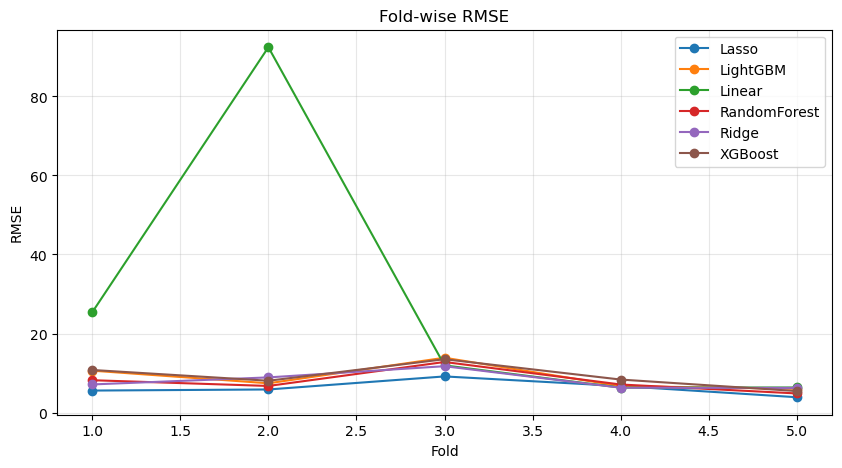

,Model,Fold,RMSE,MSE,MAE,MAPE,R²
0,Linear,1,25.382076,644.249806,23.364157,44.203959,-4.336224
1,Linear,2,92.440798,8545.301145,50.353511,75.040820,-30.480786
2,Linear,3,11.938865,142.536499,9.051551,11.669519,0.870845
3,Linear,4,6.311812,39.838967,4.592021,7.824284,0.874097
4,Linear,5,6.346498,40.278041,4.834580,6.522060,0.706960


In [14]:
# --- TimeSeriesSplit CV runner with plots ---
def run_time_series_cv(models_dict, X, y, n_splits=5, metrics_fn=None):
    if metrics_fn is None:
        raise ValueError('Provide metrics_fn (e.g., regression_metrics)')
    tscv = TimeSeriesSplit(n_splits=n_splits)
    records = []
    for name, est in models_dict.items():
        print('CV for', name)
        fold = 0
        for train_idx, val_idx in tscv.split(X):
            fold += 1
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            m = clone(est)
            m.fit(X_tr, y_tr)
            y_pred = m.predict(X_val)
            mets = metrics_fn(y_val, y_pred)
            records.append({'Model': name, 'Fold': fold, **mets})
    cv_df = pd.DataFrame(records)

    # Summary table
    summary = cv_df.groupby('Model').agg({'RMSE':['mean','std'], 'MSE':['mean','std'], 'MAE':['mean','std'], 'MAPE':['mean','std'], 'R²':['mean','std']})
    display(summary.round(4))

    # Boxplots for distributions
    metrics_to_plot = ['RMSE','MSE','MAE','MAPE']
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(5*len(metrics_to_plot),4))
    for ax, metric in zip(axes, metrics_to_plot):
        sns.boxplot(x='Model', y=metric, data=cv_df, ax=ax)
        ax.set_title(metric)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # Fold-wise RMSE
    plt.figure(figsize=(10,5))
    for name, grp in cv_df.groupby('Model'):
        plt.plot(grp['Fold'], grp['RMSE'], marker='o', label=name)
    plt.xlabel('Fold'); plt.ylabel('RMSE'); plt.title('Fold-wise RMSE'); plt.legend(); plt.grid(alpha=0.3)
    plt.show()

    return cv_df

# Run CV on training data (scaled)
cv_results = run_time_series_cv(models, X_train_scaled, y_train, n_splits=5, metrics_fn=regression_metrics)
cv_results.head()

In [17]:
# --- Small randomized search for RandomForest / XGBoost (limit iterations) ---
from scipy.stats import randint, uniform

param_grids = {}
if "RandomForest" in models:
    param_grids["RandomForest"] = {
        "n_estimators": [100, 200, 400],
        "max_depth": [5, 10, 20, None],
        "min_samples_leaf": [1, 2, 4]
    }
if "XGBoost" in models:
    param_grids["XGBoost"] = {
        "n_estimators": [100, 200, 400],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1]
    }

best_estimators = {}
tscv = TimeSeriesSplit(n_splits=3)

# IMPORTANT: set n_jobs=1 for RandomizedSearchCV to avoid subprocess/multiprocessing backend
for name in ["RandomForest", "XGBoost"]:
    if name in models and name in param_grids:
        print("Tuning", name)
        rs = RandomizedSearchCV(
            models[name],
            param_distributions=param_grids[name],
            n_iter=6,
            cv=tscv,
            scoring="neg_mean_squared_error",
            # n_jobs=1,              # <-- no parallel workers
            random_state=42,
            verbose=1
        )
        rs.fit(X_train_scaled, y_train)
        best_estimators[name] = rs.best_estimator_
        print(name, "best params:", rs.best_params_, "best score:", rs.best_score_)
    elif name in models:
        best_estimators[name] = models[name]

# fill in other models as their base clones
for k, v in models.items():
    if k not in best_estimators:
        best_estimators[k] = clone(v)

best_estimators.keys()

Tuning RandomForest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
RandomForest best params: {'n_estimators': 400, 'min_samples_leaf': 4, 'max_depth': None} best score: -70.35260794528013
Tuning XGBoost
Fitting 3 folds for each of 6 candidates, totalling 18 fits
RandomForest best params: {'n_estimators': 400, 'min_samples_leaf': 4, 'max_depth': None} best score: -70.35260794528013
Tuning XGBoost
Fitting 3 folds for each of 6 candidates, totalling 18 fits
XGBoost best params: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01} best score: -79.61886227004028
XGBoost best params: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01} best score: -79.61886227004028


dict_keys(['RandomForest', 'XGBoost', 'Linear', 'Ridge', 'Lasso', 'LightGBM'])


Training final model: RandomForest


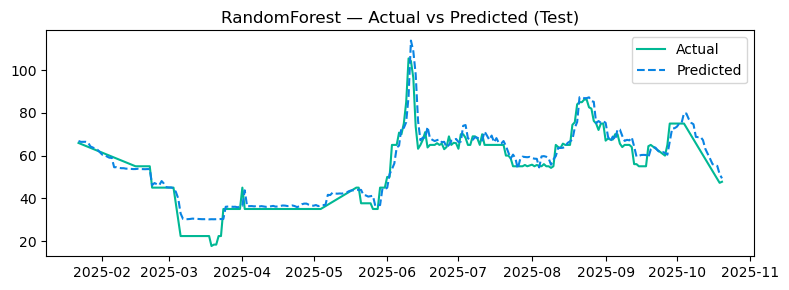


Training final model: XGBoost


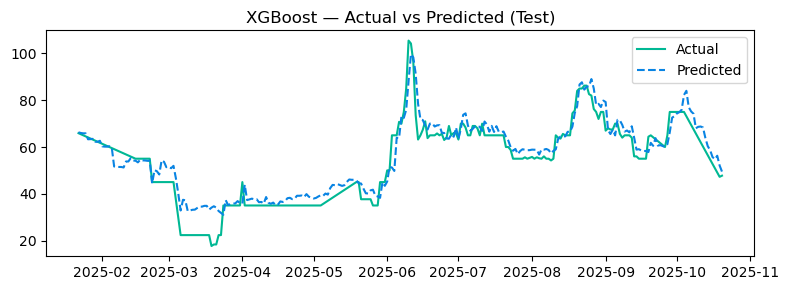


Training final model: Linear


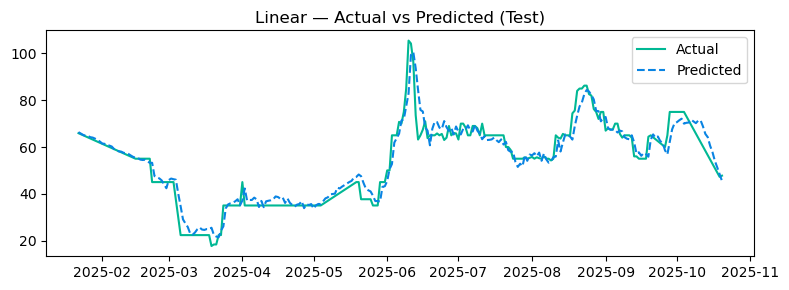


Training final model: Ridge


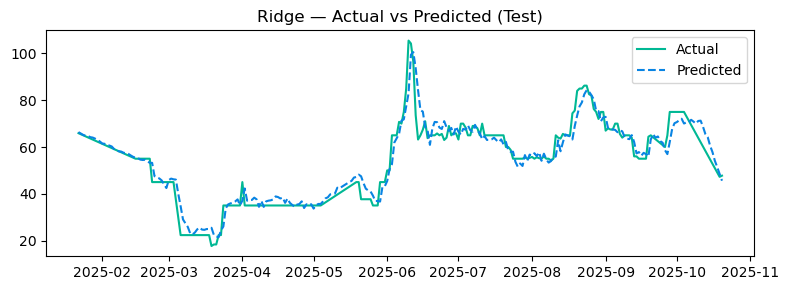


Training final model: Lasso


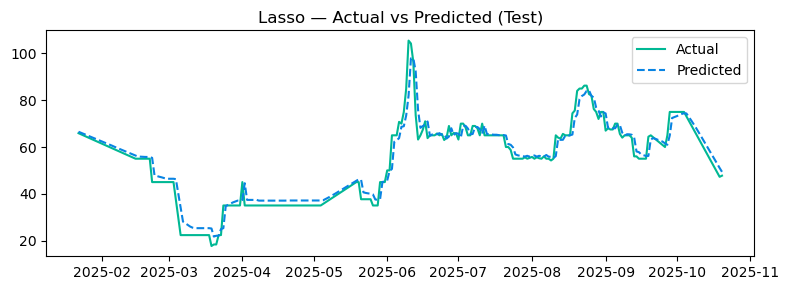


Training final model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7496
[LightGBM] [Info] Number of data points in the train set: 1087, number of used features: 48
[LightGBM] [Info] Start training from score 66.351113


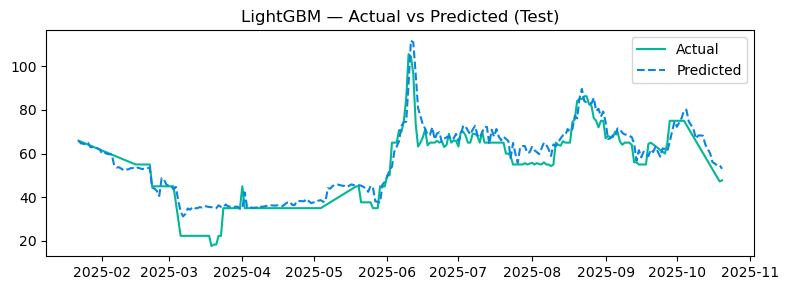

,Model,RMSE,MSE,MAE,MAPE,R²
4,Lasso,3.8797,15.0518,2.5290,5.5182,0.9457
3,Ridge,4.3887,19.2605,2.9509,6.0396,0.9306
2,Linear,4.4043,19.3981,2.9613,6.0559,0.9301
0,RandomForest,4.6437,21.5635,3.3548,7.7345,0.9223
1,XGBoost,5.4843,30.0775,4.0879,10.0367,0.8916
5,LightGBM,5.8172,33.8395,4.3005,10.4285,0.8780


In [18]:
# --- Train best estimators on full training set and evaluate on test set ---
eval_records = []
for name, model in best_estimators.items():
    print('\nTraining final model:', name)
    m = clone(model)
    m.fit(X_train_scaled, y_train)
    y_pred = m.predict(X_test_scaled)
    mets = regression_metrics(y_test, y_pred)
    eval_records.append({'Model': name, **mets})
    # Plot Actual vs Predicted
    plt.figure(figsize=(8,3))
    plt.plot(y_test.index, y_test.values, label='Actual', color='#00B894')
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--', color='#0984e3')
    plt.title(f'{name} — Actual vs Predicted (Test)')
    plt.legend(); plt.tight_layout(); plt.show()

eval_df = pd.DataFrame(eval_records).sort_values('RMSE')
display(eval_df.round(4))
eval_df.to_csv('test_performance_summary.csv', index=False)

In [19]:
# --- SHAP & Permutation Importance for top model ---
top_model_name = eval_df.sort_values('RMSE').iloc[0]['Model']
print('Top model is', top_model_name)
top_model = best_estimators[top_model_name]

# Fit top model on full training set (if not already)
top_model = clone(top_model)
top_model.fit(X_train_scaled, y_train)

# Permutation importance (if eli5 present)
if eli5 is not None:
    perm = PermutationImportance(top_model, random_state=42).fit(X_test_scaled, y_test)
    try:
        import eli5
        imp_df = eli5.format_as_dataframe(eli5.explain_weights_df(perm, feature_names=list(X_test_scaled.columns)))
        print('Top permutation importance:')
        display(imp_df.head(20))
    except Exception as e:
        print('Permutation importance formatting failed:', e)
else:
    print('eli5 not installed — skipping permutation importance')

# SHAP (TreeExplainer for trees) — may be heavy
if shap is not None:
    try:
        if hasattr(top_model, 'predict') and (top_model.__class__.__name__.lower().find('xgb')>=0 or top_model.__class__.__name__.lower().find('randomforest')>=0 or top_model.__class__.__name__.lower().find('lgb')>=0):
            expl = shap.TreeExplainer(top_model)
            shap_vals = expl.shap_values(X_test_scaled)
            print('SHAP summary (bar)')
            shap.summary_plot(shap_vals, X_test_scaled, plot_type='bar', show=True)
        else:
            print('Model not tree-based; SHAP KernelExplainer would be slow. Skipping by default.')
    except Exception as e:
        print('SHAP failed:', e)
else:
    print('shap not installed — skipping SHAP')

Top model is Lasso
Permutation importance formatting failed: 'DataFrame' object has no attribute 'transition_features'
Model not tree-based; SHAP KernelExplainer would be slow. Skipping by default.
Permutation importance formatting failed: 'DataFrame' object has no attribute 'transition_features'
Model not tree-based; SHAP KernelExplainer would be slow. Skipping by default.


In [20]:
# --- Top-5 absolute errors and feature snapshots ---
def top_n_errors(y_true, y_pred, X_test, n=5):
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true, index=X_test.index)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=X_test.index)
    abs_err = (y_true - y_pred).abs()
    top_idx = abs_err.nlargest(n).index
    rows = []
    for idx in top_idx:
        rows.append({'Date': idx, 'Actual': float(y_true.loc[idx]), 'Predicted': float(y_pred.loc[idx]), 'AbsError': float(abs_err.loc[idx]), 'Features': X_test.loc[idx].to_dict()})
    return pd.DataFrame(rows)

y_pred_top = top_model.predict(X_test_scaled)
top_errors_df = top_n_errors(y_test, y_pred_top, X_test_scaled, n=5)
print('Top 5 errors:')
display(top_errors_df)

Top 5 errors:


,Date,Actual,Predicted,AbsError,Features
0,2025-06-10,105.50,81.910721,23.589279,"{'Supply_Volume': -0.5639660074237652, 'Temper..."
1,2025-06-13,73.60,92.306014,18.706014,"{'Supply_Volume': -0.5639660074237652, 'Temper..."
2,2025-06-03,65.00,50.640353,14.359647,"{'Supply_Volume': -0.2504754106580916, 'Temper..."
3,2025-06-14,63.20,75.848683,12.648683,"{'Supply_Volume': -0.5639660074237652, 'Temper..."
4,2025-03-06,22.33,34.183928,11.853928,"{'Supply_Volume': -0.5639660074237652, 'Temper..."


In [ ]:
# --- Ablation study for top model: remove feature groups and evaluate ---
feature_groups = {
    'All': list(X_train_scaled.columns),
    'No_Market': [c for c in X_train_scaled.columns if not any(k in c.lower() for k in ['indian','supply'])],
    'No_Climate': [c for c in X_train_scaled.columns if not any(k in c.lower() for k in ['rain','temp','monsoon'])],
    'No_Economic': [c for c in X_train_scaled.columns if not any(k in c.lower() for k in ['diesel','inflation','usd'])],
}

def ablation_for_model(model, X_tr, X_te, y_tr, y_te, groups):
    rows = []
    for name, feats in groups.items():
        valid = [f for f in feats if f in X_tr.columns]
        if len(valid)==0:
            rows.append({'Configuration':name,'RMSE':np.nan,'MAE':np.nan,'R²':np.nan})
            continue
        m = clone(model)
        m.fit(X_tr[valid], y_tr)
        y_p = m.predict(X_te[valid])
        mets = regression_metrics(y_te, y_p)
        rows.append({'Configuration':name, **mets})
    return pd.DataFrame(rows)

ablation_res = ablation_for_model(top_model, X_train_scaled, X_test_scaled, y_train, y_test, feature_groups)
print('Ablation results for top model:')
display(ablation_res.round(4))

# Plot ablation RMSE
plt.figure(figsize=(8,4))
sns.barplot(x='Configuration', y='RMSE', data=ablation_res.reset_index())
plt.title('Ablation: RMSE across feature group removals')
plt.tight_layout(); plt.show()

In [ ]:
# --- Simple recursive 7-day forecast using top_model ---
horizon = 7
last_row = df_processed.iloc[-1].copy()
future_dates = pd.date_range(start=df_processed.index[-1] + pd.Timedelta(days=1), periods=horizon)
preds = []
prev = last_row.copy()
for d in future_dates:
    new = prev.copy()
    # update lags: shift previous target into lag_1 etc.
    if 'Average_Price' in prev.index or 'Average_Price' in prev:
        pass
    # Build row following same columns as X_train
    row = {}
    for col in X_train.columns:
        if col.startswith('Average_Price_lag_1') or col.endswith('_lag_1'):
            # use last known price
            row[col] = prev['Average_Price']
        else:
            row[col] = prev.get(col, np.nan)
    row_df = pd.DataFrame([row], index=[d])
    # scale numeric cols
    row_scaled = row_df.copy()
    row_scaled[scale_cols] = scaler.transform(row_df[scale_cols])
    # ensure columns order
    row_scaled = row_scaled.reindex(columns=X_train_scaled.columns)
    next_pred = top_model.predict(row_scaled)[0]
    preds.append(next_pred)
    # update prev row's Average_Price for next iteration
    prev['Average_Price'] = next_pred

forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Average_Price': preds}).set_index('Date')
print('7-day forecast (top model)')
display(forecast_df.round(2))

# Plot last 30 days + forecast
plt.figure(figsize=(10,4))
plt.plot(df_processed.index[-30:], df_processed['Average_Price'].iloc[-30:], label='Actual (last 30)')
plt.plot(forecast_df.index, forecast_df['Predicted_Average_Price'], marker='o', linestyle='--', label='Forecast')
plt.legend(); plt.title('Top model: 7-day recursive forecast'); plt.tight_layout(); plt.show()

In [ ]:
# --- Simple ARIMA / SARIMA forecasts (target-only) ---
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    y_series = df['Average_Price'].asfreq('D').interpolate('time')
    arima_fit = ARIMA(y_series, order=(1,1,1)).fit()
    arima_fore = arima_fit.forecast(7)
    sarima_fit = SARIMAX(y_series, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
    sarima_fore = sarima_fit.forecast(7)
    arima_df = pd.DataFrame({'ARIMA': arima_fore, 'SARIMA': sarima_fore}).round(2)
    display(arima_df)
except Exception as e:
    print('statsmodels not available or ARIMA failed:', e)

In [ ]:
# --- EDA visualizations: correlation & pairplot (numeric only) ---
num = df_processed.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
sns.heatmap(num.corr(), annot=False, cmap='coolwarm')
plt.title('Numeric feature correlation (processed)'); plt.show()

# Pairplot of selected important variables (limit columns for speed)
cols = ['Average_Price','indian_tomato_price','Supply_Volume']
cols = [c for c in cols if c in df_processed.columns]
if len(cols)>=2:
    sns.pairplot(df_processed[cols].sample(min(500, len(df_processed))), diag_kind='kde')
    plt.suptitle('Pairwise plots (sample)'); plt.show()


### Notebook summary

- Feature engineering: lags and rolling statistics for Average_Price, Temperature, Rainfall_MM, Supply_Volume, plus cyclical time features.
- Preprocessing: time-aware train/test split and scaling (fit on train only).
- Metrics: RMSE, MSE, MAE, MAPE (safe), R².
- TimeSeriesSplit cross validation with boxplots and fold-wise RMSE stability plots.
- Small randomized hyperparameter search for tree models.
- Final evaluation on test set with Actual vs Predicted plots.
- Interpretability: SHAP (tree models) and permutation importance (eli5) if installed.
- Top‑5 error analysis and ablation study for the top model.
- Simple recursive 7‑day forecast with top model and ARIMA/SARIMA forecasts.

If you'd like, I can:
- Reduce runtime (fewer CV folds, smaller param grids),
- Save trained models to disk,
- Export plots and tables to files,
- Wrap this pipeline into functions or a script for scheduled runs.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap
from datetime import datetime, timedelta

sns.set(style="whitegrid")

# --- 1) Multi-model recursive forecast from 2025-10-20 for 7 days ---
def multi_model_recursive_forecast(models_dict, df_hist, start_date_str="2025-10-20", horizon=7, X_columns=None, scaler=None, scale_cols=None):
    """
    Returns DataFrame of shape (horizon x n_models) with predictions.
    - models_dict: name->fitted estimator (or cloneable)
    - df_hist: processed dataframe (has Average_Price and engineered feature columns)
    - start_date_str: first forecast date (YYYY-MM-DD)
    - X_columns: expected feature columns (order)
    - scaler, scale_cols: scaler and list of numeric cols used to scale
    """
    start_date = pd.to_datetime(start_date_str)
    # Ensure we have historical prices up to day before start_date. If start_date <= last historical date,
    # begin forecasts from the next day after start_date provided.
    last_hist_date = df_hist.index.max()
    if start_date <= last_hist_date:
        print(f"Start date {start_date.date()} <= last history {last_hist_date.date()}, forecasting from next day.")
        start_date = last_hist_date + pd.Timedelta(days=1)

    future_dates = [start_date + pd.Timedelta(days=i) for i in range(horizon)]

    # price history series used to compute lags/rolling
    price_hist = df_hist["Average_Price"].copy()

    preds = {name: [] for name in models_dict.keys()}

    # helper to build row dict for a given forecast date using price_hist + last known features
    def build_row_for_date(fdate):
        last_row = df_hist.iloc[-1].to_dict()
        row = {}
        for col in X_columns:
            # handle common engineered patterns
            if col.startswith("Average_Price_lag_"):
                k = int(col.split("_")[-1])
                if len(price_hist) >= k:
                    row[col] = float(price_hist.iloc[-k])
                else:
                    row[col] = float(price_hist.iloc[-1])  # fallback
            elif "rollmean" in col or "rollstd" in col:
                # parse window size
                try:
                    w = int(col.split("_")[-1])
                    # compute rolling on price_hist
                    if len(price_hist) >= 1:
                        if "rollmean" in col:
                            row[col] = float(price_hist.tail(w).mean())
                        else:
                            row[col] = float(price_hist.tail(w).std())
                    else:
                        row[col] = float(price_hist.iloc[-1])
                except Exception:
                    row[col] = last_row.get(col, np.nan)
            elif col in ["Month","DayOfWeek","Year","Month_sin","Month_cos","Dow_sin","Dow_cos"]:
                # time features based on forecast date
                if col == "Month":
                    row[col] = fdate.month
                elif col == "DayOfWeek":
                    row[col] = fdate.dayofweek
                elif col == "Year":
                    row[col] = fdate.year
                elif col == "Month_sin":
                    row[col] = np.sin(2 * np.pi * fdate.month / 12)
                elif col == "Month_cos":
                    row[col] = np.cos(2 * np.pi * fdate.month / 12)
                elif col == "Dow_sin":
                    row[col] = np.sin(2 * np.pi * fdate.dayofweek / 7)
                elif col == "Dow_cos":
                    row[col] = np.cos(2 * np.pi * fdate.dayofweek / 7)
            else:
                # feature not engineered: use last known value if present
                row[col] = last_row.get(col, np.nan)
        return row

    # iterate horizon
    for d in future_dates:
        row = build_row_for_date(d)
        row_df = pd.DataFrame([row], index=[d])
        # scale numeric columns if scaler provided
        if scaler is not None and len(scale_cols)>0:
            # ensure missing scale_cols exist in row_df
            for c in scale_cols:
                if c not in row_df.columns:
                    row_df[c] = np.nan
            # fill NA with last known medians from df_hist
            row_df[scale_cols] = row_df[scale_cols].fillna(df_hist[scale_cols].median())
            row_df_scaled = row_df.copy()
            row_df_scaled[scale_cols] = scaler.transform(row_df[scale_cols])
        else:
            row_df_scaled = row_df.copy()
        # ensure columns order
        row_df_scaled = row_df_scaled.reindex(columns=X_columns).fillna(0)
        # predict for each model
        for name, model in models_dict.items():
            try:
                pred = model.predict(row_df_scaled)[0]
            except Exception:
                # if model not trained, clone+fit on last train slice not available here; set nan
                pred = np.nan
            preds[name].append(float(pred))
        # append predicted price to price_hist for next-step lag computation (use average of models? pick top model if exists)
        # We'll append median prediction across models to reduce variance
        median_pred = np.nanmedian([preds[n][-1] for n in preds.keys()])
        price_hist = price_hist.append(pd.Series([median_pred], index=[d]))
    forecast_df = pd.DataFrame(preds, index=future_dates)
    return forecast_df

# Build models_dict (use best_estimators if present, else models)
models_dict = globals().get("best_estimators", None) or globals().get("models", None)
if models_dict is None:
    raise RuntimeError("models or best_estimators not found. Run model training first.")

# Ensure X_columns and scale_cols exist
X_columns = list(globals().get("X_train").columns) if "X_train" in globals() else list(globals().get("X_train_scaled").columns)
scale_cols = globals().get("scale_cols", [])
scaler_obj = globals().get("scaler", None)

# Run forecast from 2025-10-20 for 7 days
forecast_start = "2025-10-20"
horizon = 7
multi_fc = multi_model_recursive_forecast(models_dict, df_processed, start_date_str=forecast_start, horizon=horizon, X_columns=X_columns, scaler=scaler_obj, scale_cols=scale_cols)
print(f"Multi-model forecasts from {forecast_start} (horizon={horizon}):")
display(multi_fc.round(2))

# Plot forecasts comparison
plt.figure(figsize=(10,4))
for col in multi_fc.columns:
    plt.plot(multi_fc.index, multi_fc[col], marker='o', label=col)
plt.title(f"Model forecasts from {forecast_start} for {horizon} days")
plt.xlabel("Date"); plt.ylabel("Predicted Average_Price"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 2) Robust permutation importance (sklearn) and SHAP (safe) for top model ---
from sklearn.inspection import permutation_importance as sk_permutation_importance
top_name = eval_df.sort_values("RMSE").iloc[0]["Model"]
top_model = best_estimators.get(top_name, best_estimators.get(list(best_estimators.keys())[0]))
print("Top model:", top_name)

# Permutation importance (sklearn) - faster and no external deps
try:
    pi = sk_permutation_importance(top_model, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=1)
    pi_df = pd.DataFrame({"feature": X_test_scaled.columns, "importance_mean": pi.importances_mean, "importance_std": pi.importances_std})
    pi_df = pi_df.sort_values("importance_mean", ascending=False).reset_index(drop=True)
    print("Top permutation importances (sklearn):")
    display(pi_df.head(20))
    # Plot top 15
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance_mean", y="feature", data=pi_df.head(15), palette="viridis", xerr=pi_df.head(15)["importance_std"].values)
    plt.title(f"Permutation importance (top {min(15,len(pi_df))}) for {top_name}")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Permutation importance failed:", e)

# SHAP for tree models - safe guard
if shap is not None:
    try:
        model_class = top_model.__class__.__name__.lower()
        if any(k in model_class for k in ["xgb","lgb","randomforest","forest","gbm"]):
            expl = shap.TreeExplainer(top_model)
            shap_vals = expl.shap_values(X_test_scaled)
            print("Plotting SHAP summary (bar)")
            shap.summary_plot(shap_vals, X_test_scaled, plot_type="bar", show=True)
        else:
            print("Top model is not recognized as tree-based; skipping TreeExplainer SHAP.")
    except Exception as e:
        print("SHAP failed or too slow:", e)
else:
    print("shap not available in environment; skip SHAP.")

# --- 3) Top-5 error analysis with plots to explain WHY they were bad ---
def plot_top_error_explanations(y_true, y_pred, X_test, n=5, window=7):
    # Ensure series
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true, index=X_test.index)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=X_test.index)
    abs_err = (y_true - y_pred).abs()
    top_idx = abs_err.nlargest(n).index
    figs = []
    for idx in top_idx:
        start = idx - pd.Timedelta(days=window)
        end = idx + pd.Timedelta(days=window)
        ts_idx = X_test.index[(X_test.index >= start) & (X_test.index <= end)]
        # plot time series actual vs predicted (top model)
        plt.figure(figsize=(10,3))
        plt.plot(ts_idx, y_true.reindex(ts_idx), label="Actual", color="#00B894")
        plt.plot(ts_idx, y_pred.reindex(ts_idx), label="Predicted", color="#0984e3", linestyle="--")
        plt.axvline(idx, color="red", linestyle=":", label=f"Error date {idx.date()}")
        plt.title(f"Error window around {idx.date()} (AbsError={abs_err.loc[idx]:.2f})")
        plt.legend(); plt.tight_layout(); plt.show()
        # feature snapshot bar: show top 12 numeric features values at that date vs median
        feat_row = X_test.loc[idx]
        numeric_feats = feat_row.select_dtypes(include=[np.number]).index.tolist()
        if len(numeric_feats) == 0:
            print("No numeric features to plot for explanation.")
            continue
        # compute deviation from median (test)
        medians = X_test[numeric_feats].median()
        diffs = (feat_row[numeric_feats] - medians).abs().sort_values(ascending=False).head(12)
        vals = feat_row[diffs.index]
        # plot values and medians for context
        df_plot = pd.DataFrame({"value": vals.values, "median": medians[diffs.index].values}, index=diffs.index)
        df_plot_norm = (df_plot - df_plot.mean())/ (df_plot.std() + 1e-9)  # normalized for comparability
        plt.figure(figsize=(8,4))
        df_plot_norm["value"].plot.barh(color="#74b9ff")
        plt.title(f"Top feature deviations (normalized) at {idx.date()} — helps explain the large error")
        plt.tight_layout(); plt.show()

# run explanation using top_model predictions
y_pred_top_series = pd.Series(top_model.predict(X_test_scaled), index=X_test_scaled.index)
plot_top_error_explanations(y_test, y_pred_top_series, X_test_scaled, n=5, window=7)

# --- 4) Improved ablation figure for best model (RMSE + MAE) ---
if 'ablation_res' in globals():
    ar = ablation_res.copy().reset_index(drop=True)
    ar_melt = ar.melt(id_vars=["Configuration"], value_vars=["RMSE","MAE"], var_name="Metric", value_name="Value")
    plt.figure(figsize=(8,4))
    sns.barplot(data=ar_melt, x="Configuration", y="Value", hue="Metric", palette="Set2")
    plt.title(f"Ablation results for top model: {top_name}")
    plt.tight_layout(); plt.show()
else:
    print("ablation_res not found. Please run ablation cell first.")